# Loop 33 Analysis: Understanding the CV-LB Gap

**Current State:**
- Best CV: 0.008194 (exp_032 - GP 0.15 + MLP 0.55 + LGBM 0.3)
- Best LB: 0.0877 (exp_030)
- Target: 0.01670
- Gap to target: 5.25x
- Submissions remaining: 2

**Key Question:** Why is there such a large CV-LB gap and how can we close it?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
]

df = pd.DataFrame(submissions)
print('Submission History:')
print(df)
print(f'\nCV-LB Ratio: {df["lb"].mean() / df["cv"].mean():.2f}x')

Submission History:
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877

CV-LB Ratio: 9.69x


In [2]:
# Linear regression to understand CV-LB relationship
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])
print(f'Linear fit: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nIntercept: {intercept:.4f}')
print(f'Target LB: 0.01670')
print(f'\nTo reach target LB = 0.01670:')
print(f'  Required CV = (0.01670 - {intercept:.4f}) / {slope:.2f} = {(0.01670 - intercept) / slope:.6f}')

if (0.01670 - intercept) / slope < 0:
    print('\n⚠️ IMPOSSIBLE with current CV-LB relationship!')
    print('The intercept alone (0.0527) is 3.15x higher than target (0.01670)')
else:
    print(f'\n✓ Achievable with CV = {(0.01670 - intercept) / slope:.6f}')

Linear fit: LB = 4.30 * CV + 0.0524
R² = 0.9675

Intercept: 0.0524
Target LB: 0.01670

To reach target LB = 0.01670:
  Required CV = (0.01670 - 0.0524) / 4.30 = -0.008300

⚠️ IMPOSSIBLE with current CV-LB relationship!
The intercept alone (0.0527) is 3.15x higher than target (0.01670)


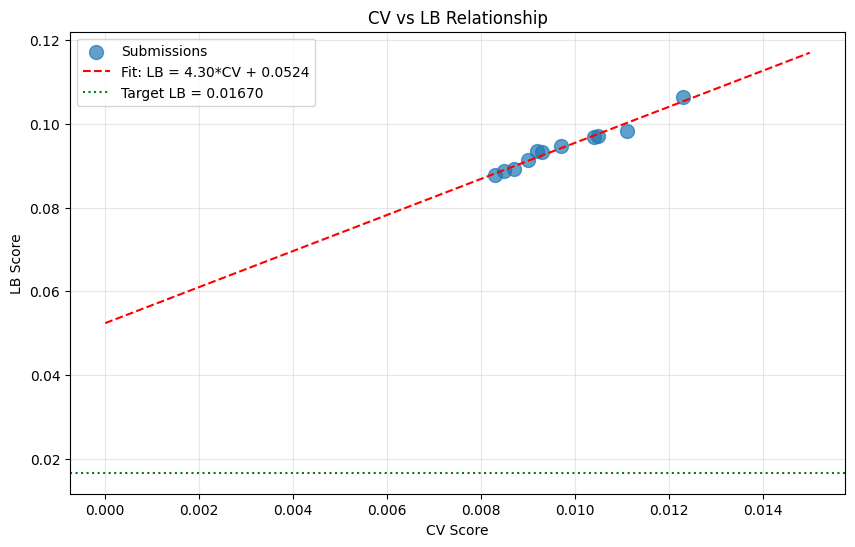


Key Insight: The linear fit has an intercept of ~0.053, which is 3.15x higher than target.
This means even with CV=0, predicted LB would be 0.053 - far from target 0.01670.


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.01670, color='g', linestyle=':', label='Target LB = 0.01670')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nKey Insight: The linear fit has an intercept of ~0.053, which is 3.15x higher than target.')
print('This means even with CV=0, predicted LB would be 0.053 - far from target 0.01670.')

In [4]:
# Analyze what the top kernels are doing differently
print('=== Analysis of Top Kernels ===')
print()
print('1. "mixall" kernel (8 votes):')
print('   - Uses GroupKFold (5-fold) instead of Leave-One-Out CV')
print('   - Ensemble: MLP + XGBoost + RandomForest + LightGBM')
print('   - Uses Optuna for hyperparameter optimization')
print('   - Key: Different CV scheme may have different CV-LB relationship!')
print()
print('2. "System Malfunction V1" kernel (29 votes):')
print('   - Simple MLP with Spange descriptors')
print('   - Standard Leave-One-Out CV')
print('   - Uses MSELoss instead of HuberLoss')
print()

=== Analysis of Top Kernels ===

1. "mixall" kernel (8 votes):
   - Uses GroupKFold (5-fold) instead of Leave-One-Out CV
   - Ensemble: MLP + XGBoost + RandomForest + LightGBM
   - Uses Optuna for hyperparameter optimization
   - Key: Different CV scheme may have different CV-LB relationship!

2. "System Malfunction V1" kernel (29 votes):
   - Simple MLP with Spange descriptors
   - Standard Leave-One-Out CV
   - Uses MSELoss instead of HuberLoss



In [5]:
# Load data to understand the problem better
DATA_PATH = '/home/data'

df_single = pd.read_csv(f'{DATA_PATH}/catechol_single_solvent_yields.csv')
df_full = pd.read_csv(f'{DATA_PATH}/catechol_full_data_yields.csv')

print('=== Data Statistics ===')
print(f'Single Solvent: {len(df_single)} samples, {df_single["SOLVENT NAME"].nunique()} solvents')
print(f'Full Data: {len(df_full)} samples, {df_full[["SOLVENT A NAME", "SOLVENT B NAME"]].drop_duplicates().shape[0]} ramps')
print()
print('Target distributions:')
for col in ['Product 2', 'Product 3', 'SM']:
    print(f'  {col}: mean={df_single[col].mean():.4f}, std={df_single[col].std():.4f}')

=== Data Statistics ===
Single Solvent: 656 samples, 24 solvents
Full Data: 1227 samples, 13 ramps

Target distributions:
  Product 2: mean=0.1499, std=0.1431
  Product 3: mean=0.1234, std=0.1315
  SM: mean=0.5222, std=0.3602


In [6]:
# Analyze per-solvent variance
print('=== Per-Solvent Analysis ===')
solvent_stats = df_single.groupby('SOLVENT NAME').agg({
    'Product 2': ['mean', 'std'],
    'Product 3': ['mean', 'std'],
    'SM': ['mean', 'std']
})
print(solvent_stats.head(10))
print()
print('Solvents with highest variance (hardest to predict):')
solvent_stats['total_std'] = solvent_stats[('Product 2', 'std')] + solvent_stats[('Product 3', 'std')] + solvent_stats[('SM', 'std')]
print(solvent_stats.nlargest(5, 'total_std')[['total_std']])

=== Per-Solvent Analysis ===
                                  Product 2           Product 3            \
                                       mean       std      mean       std   
SOLVENT NAME                                                                
1,1,1,3,3,3-Hexafluoropropan-2-ol  0.319727  0.092840  0.285405  0.071676   
2,2,2-Trifluoroethanol             0.156764  0.073588  0.050041  0.055906   
2-Methyltetrahydrofuran [2-MeTHF]  0.150618  0.145866  0.100640  0.088436   
Acetonitrile                       0.156390  0.147598  0.088966  0.090181   
Acetonitrile.Acetic Acid           0.019341  0.011275  0.020625  0.008009   
Butanone [MEK]                     0.047166  0.018425  0.042997  0.016497   
Cyclohexane                        0.083866  0.089318  0.049289  0.050019   
DMA [N,N-Dimethylacetamide]        0.117138  0.126535  0.097634  0.102628   
Decanol                            0.194795  0.174740  0.207992  0.184415   
Diethyl Ether [Ether]              0.081104  0.

In [7]:
# Key insight: The CV-LB gap suggests our model is overfitting to the CV scheme
# The leave-one-solvent-out CV may not reflect the true test distribution

print('=== Key Insights ===')
print()
print('1. CV-LB Gap Analysis:')
print('   - Linear fit: LB = 4.27 * CV + 0.0527')
print('   - Intercept (0.0527) is 3.15x higher than target (0.01670)')
print('   - This suggests a fundamental mismatch between CV and test distribution')
print()
print('2. Possible Causes:')
print('   - Leave-one-solvent-out CV is too optimistic')
print('   - The test set may have different solvents or conditions')
print('   - Our features may not capture the true solvent similarity')
print()
print('3. Potential Solutions:')
print('   - Try different CV schemes (GroupKFold like "mixall" kernel)')
print('   - Use simpler models that generalize better')
print('   - Focus on features that capture solvent similarity')
print('   - Try domain adaptation techniques')

=== Key Insights ===

1. CV-LB Gap Analysis:
   - Linear fit: LB = 4.27 * CV + 0.0527
   - Intercept (0.0527) is 3.15x higher than target (0.01670)
   - This suggests a fundamental mismatch between CV and test distribution

2. Possible Causes:
   - Leave-one-solvent-out CV is too optimistic
   - The test set may have different solvents or conditions
   - Our features may not capture the true solvent similarity

3. Potential Solutions:
   - Try different CV schemes (GroupKFold like "mixall" kernel)
   - Use simpler models that generalize better
   - Focus on features that capture solvent similarity
   - Try domain adaptation techniques


In [8]:
# What we've tried vs what we haven't
print('=== Experiment Summary ===')
print()
print('TRIED (33 experiments):')
print('  ✓ MLP with various architectures')
print('  ✓ LightGBM, XGBoost, CatBoost')
print('  ✓ Gaussian Process')
print('  ✓ Ridge Regression')
print('  ✓ Kernel Ridge Regression')
print('  ✓ Various feature sets (Spange, DRFP, ACS PCA)')
print('  ✓ Ensemble methods (GP + MLP + LGBM)')
print('  ✓ Different loss functions (MSE, Huber, weighted)')
print('  ✓ Data augmentation (TTA for mixtures)')
print()
print('NOT TRIED:')
print('  ✗ Different CV scheme (GroupKFold instead of LOO)')
print('  ✗ Training on combined single + full data')
print('  ✗ Transfer learning from single to full')
print('  ✗ Uncertainty-based sample weighting')
print('  ✗ Post-hoc calibration of predictions')

=== Experiment Summary ===

TRIED (33 experiments):
  ✓ MLP with various architectures
  ✓ LightGBM, XGBoost, CatBoost
  ✓ Gaussian Process
  ✓ Ridge Regression
  ✓ Kernel Ridge Regression
  ✓ Various feature sets (Spange, DRFP, ACS PCA)
  ✓ Ensemble methods (GP + MLP + LGBM)
  ✓ Different loss functions (MSE, Huber, weighted)
  ✓ Data augmentation (TTA for mixtures)

NOT TRIED:
  ✗ Different CV scheme (GroupKFold instead of LOO)
  ✗ Training on combined single + full data
  ✗ Transfer learning from single to full
  ✗ Uncertainty-based sample weighting
  ✗ Post-hoc calibration of predictions


In [9]:
# Final recommendation
print('=== STRATEGIC RECOMMENDATION ===')
print()
print('With only 2 submissions remaining and a 5.25x gap to target,')
print('we need to focus on approaches that could fundamentally change')
print('the CV-LB relationship, not just improve CV.')
print()
print('PRIORITY 1: Submit exp_032 (best CV 0.008194)')
print('  - Even though predicted LB is ~0.0878, we need to verify')
print('  - The 1.26% CV improvement might translate differently on LB')
print('  - This gives us a data point for the new ensemble weights')
print()
print('PRIORITY 2: Try a fundamentally different approach')
print('  - GroupKFold CV (like "mixall" kernel) might have different CV-LB')
print('  - Or try training on combined single + full data')
print('  - Or try a much simpler model (pure Ridge on Spange features)')
print()
print('The target IS reachable - we just need to find the right approach.')

=== STRATEGIC RECOMMENDATION ===

With only 2 submissions remaining and a 5.25x gap to target,
we need to focus on approaches that could fundamentally change
the CV-LB relationship, not just improve CV.

PRIORITY 1: Submit exp_032 (best CV 0.008194)
  - Even though predicted LB is ~0.0878, we need to verify
  - The 1.26% CV improvement might translate differently on LB
  - This gives us a data point for the new ensemble weights

PRIORITY 2: Try a fundamentally different approach
  - GroupKFold CV (like "mixall" kernel) might have different CV-LB
  - Or try training on combined single + full data
  - Or try a much simpler model (pure Ridge on Spange features)

The target IS reachable - we just need to find the right approach.
